# CytoNormPy - FCS files

In this vignette, we showcase a typical analysis workflow using FCS files read from disk.

First, we import the necessary libraries

In [1]:
import cytonormpy as cnp

import os
import pandas as pd

## Metadata

In order to tell cytonormpy, which data are references used for calculating the spline functions, we provide it with a metadata file as a `pandas.DataFrame`. Here, we read it from disk, but you can also create it on the fly using the pandas library.

In [2]:
input_directory = "../_resources/"
output_directory = os.path.join(input_directory, "normalized")

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

metadata = pd.read_csv(os.path.join(input_directory, "metadata_sid.csv"))
metadata.head()

,file_name,reference,batch,sample_ID
0,Gates_PTLG021_Unstim_Control_1.fcs,ref,1,1
1,Gates_PTLG021_Unstim_Control_2.fcs,other,1,2
2,Gates_PTLG028_Unstim_Control_1.fcs,ref,2,3
3,Gates_PTLG028_Unstim_Control_2.fcs,other,2,4
4,Gates_PTLG034_Unstim_Control_1.fcs,ref,3,5


## Data setup

We instantiate the cytonorm object and add a data transformer that will transform our data to the asinh space and the clusterer that will cluster the cells.

In [3]:
cn = cnp.CytoNorm()

t = cnp.AsinhTransformer()
fs = cnp.FlowSOM(n_clusters=4)

cn.add_transformer(t)
cn.add_clusterer(fs)

The channels to be normalized are saved in a text file and will be passed to the `run_fcs_data_setup()` method.

Alternatively, valid arguments for the `channels` keyword are "markers" and "all". 

In [4]:
coding_detectors = pd.read_csv(input_directory + "coding_detectors.txt", header=None)[0].tolist()

In [5]:
cn.run_fcs_data_setup(
    input_directory=input_directory,
    metadata=metadata,
    channels=coding_detectors,
    output_directory=output_directory,
    prefix="Norm",
)

## CV thresholding

For clustering, it is important to visualize the distribution of files within one cluster. We have already added a FlowSOM Clusterer instance. the function 'calculate_cluster_cvs' will now calculate, for each metacluster number that we want to analyze, the cluster cv per sample.

We then visualize it via a waterfall plot as in the original CytoNorm implementation in R.

_CytoNorm2.0_: We can now use a different set of markers for clustering using the 'markers' parameter. If you want to use all markers, do not pass anything!

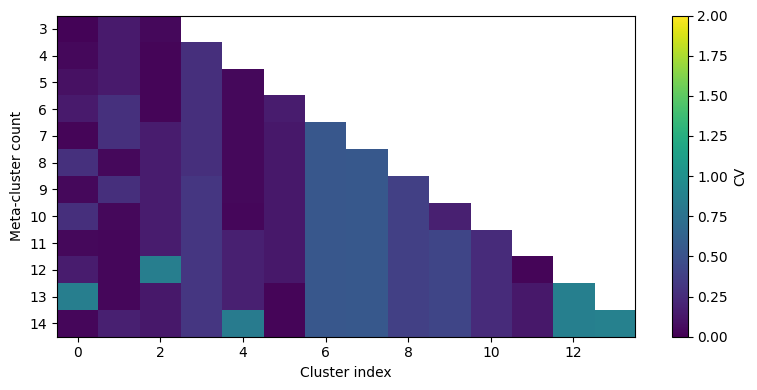

In [6]:
markers_for_clustering = coding_detectors[4:15]

cn.calculate_cluster_cvs(n_metaclusters=list(range(3, 15)), markers=markers_for_clustering)
cnp.pl.cv_heatmap(cn, n_metaclusters=list(range(3, 15)), max_cv=2)

## Clustering

We run the FlowSOM clustering and pass a `cluster_cv_threshold` of 2. This value is used to evaluate if the distribution of files within one cluster is sufficient. A warning will be raised if that is not the case.

In [7]:
cn.run_clustering(markers=markers_for_clustering, cluster_cv_threshold=2)

## Calculation

Finally, we calculate the quantiles per batch and cluster, calculate the spline functions and transform the expression values accordingly.

The data will automatically be saved to disk using the prefix `Norm_`. To change that prefix, pass the keyword `prefix` to the `.run_fcs_data_setup()` method above.

In [8]:
cn.calculate_quantiles()
cn.calculate_splines(goal="batch_mean")
cn.normalize_data()

C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 23 cells detected in batch 1 for cluster 1. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 32 cells detected in batch 1 for cluster 3. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 6 cells detected in batch 1 for cluster 4. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:524: UserWarning: 41 cells detected in batch 1 for cluster 6. Skipping quantile calculation. 
  warnings.warn(warning_msg, UserWarning)
C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_cytonorm\_cytonorm.py:52

normalized file Gates_PTLG028_Unstim_Control_1.fcs
normalized file Gates_PTLG021_Unstim_Control_1.fcs
normalized file Gates_PTLG034_Unstim_Control_1.fcs
normalized file Gates_PTLG028_Unstim_Control_2.fcs
normalized file Gates_PTLG021_Unstim_Control_2.fcs
normalized file Gates_PTLG034_Unstim_Control_2.fcs


C:\Users\tarik\anaconda3\envs\cytonorm\lib\site-packages\cytonormpy\_dataset\_dataset.py:376: RuntimeWarning: overflow encountered in cast
  orig_events[:, channel_indices] = inv_transformed.values


In order to use the cytonorm object on new data, simply pass the filenames and the batch information. You can either pass a single filename or provide a list.

In [9]:
cn.normalize_data(file_names="Gates_PTLG034_Unstim_Control_2_dup.fcs", batches=3)

normalized file Gates_PTLG034_Unstim_Control_2_dup.fcs
